In [ ]:
import math, sys
import cmath as z

!{sys.executable} -m pip install numpy matplotlib svgpathtools

In [2]:
%matplotlib notebook
import numpy as np 
import matplotlib.animation as anim 
import matplotlib.pyplot as plt
from svgpathtools import svg2paths
from IPython.display import HTML

In [3]:
# No. of vectors
N = 51
PI = math.pi

# Time signal for parameterizing curve
t = np.arange(0,N/(N-1),1/(N-1))
dt = 1/(N-1)

In [4]:
# Sample path from SVG
paths, attributes = svg2paths('note.svg')

# Find the longest path
path_length = 0
best_index = 0
for index, path in enumerate(paths):
    if path.length(error=1e-5) > path_length and path.isclosed():
        path_length = path.length(error=1e-5)
        best_index = index


# Fetch correct path from list
path = paths[best_index]
xlim1, xlim2, ylim1, ylim2 = path.bbox()  # Get SVG path bounding box dimensions
centre = (xlim1+xlim2)/2 + 1j*(ylim1+ylim2)/2  # Get centre of path to shift origin

In [5]:
# Vectors 
class epicycle:
    
    # Initialized via constants from Fourier Transform
    def __init__(self, cn, n, t): 
        self.term = cn*z.exp(n*2*PI*1j*t)
        
    # Return vector coordinates
    def data(self):
        return self.term.real, -self.term.imag  # Mirror along x-axis for CCW representation


# Returns parametric coordinates of path as complex numbers
def f(t):
    return path.point(t)-centre   # Shift origin


# Discrete Fourier Transform
def dft(n,N):
    cn = 0
    t = 0
    while t <= 1:
        cn += f(t)*z.exp(-n*2*PI*1j*t)*(1/(N-1))
        t += 1/(N-1)
    
    return cn,n


# Generator of constants for vectors
def coeff(N):    
    for n in range(N):
        n -= N//2
        yield dft(n,N)

<IPython.core.display.Javascript object>


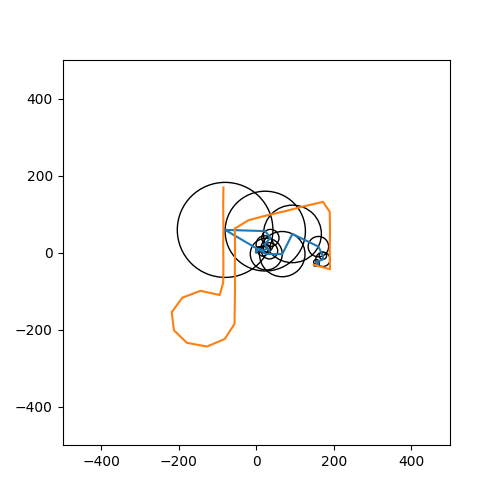

In [6]:
# Matplotlib
fig = plt.figure(figsize=(5,5))
plt.xlim(-500, 500)
plt.ylim(-500, 500)
epicycles, = plt.plot([],[])
_path, = plt.plot([],[])

def init():
    # Clear vector data before animation loop
    epicycles.set_data([],[])
    return epicycles,

def animate(t):    
    # Clear old circle artists
    for obj in plt.findobj(match=type(plt.Circle(1,1))):
        obj.remove()
                           
    # Update epicycle data and path drawn
    _x,_y = [],[]
    x, y = 0,0
    circles = []
    for cn, n in coeff(N):
        _vector = epicycle(cn,n,t)
        r,i = _vector.data()
        radius = math.sqrt(r**2 + i**2)
        _circle = plt.Circle((x,y),radius,fill=False)
        fig.gca().add_artist(_circle)
        circles.append(_circle)
        x += r
        y += i
        _x.append(x)
        _y.append(y)

    if t == 0:
        fx, fy = [],[]
    else:
        fx = _path.get_xdata()
        fy = _path.get_ydata()

    fx = np.append(fx,x)
    fy = np.append(fy,y)

    epicycles.set_data(_x, _y)
    _path.set_data(fx, fy)
    return epicycles, _path, circles

# Animate path drawing
final = anim.FuncAnimation(fig,animate,t,interval=dt*3000,blit=True,repeat_delay=200,init_func=init)
#HTML(final.to_jshtml()) ## In case the above doesn't work